In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# Fase 1 - Comprensión del negocio

En esta fase se identificarán los factores clave necesarios para abordar los objetivos empresariales y se plantearán en objetivos específicos de minería de datos, asegurando que el análisis posterior responda adecuadamente a las necesidades del negocio.

## Proyecto de Deep Learning - Dataset CIFAR-100

**Autores:** Daniel Iturra, Diego Velasquez, Jonathan Huala, Jorge Gonzales.

**Fecha:** 20-04-2025

# Fase 2 - Comprensión de los datos

Durante esta fase, se realizará una recolección y análisis preliminar de los datos disponibles, con el objetivo de comprender su naturaleza y calidad. Se identificarán patrones iniciales y posibles problemas que puedan afectar el análisis, lo que permitirá guiar el proceso de preparación de los datos.

## Exploraciones iniciales

Configuración de estilos para que las gráficas se van más limpias.

In [34]:
plt.style.use('ggplot')
sns.set()

Se cargan los datos de CIFAR-100 usando la función load_data() con label_mode='fine', lo cual significa que se usaron las 100 clases específicas del dataset.

In [8]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

Se revisan las dimensiones de los datos y las etiquetas.

In [36]:
print("Dimensiones del set de entrenamiento:", x_train.shape)
print("Dimensiones del set de prueba:", x_test.shape)

num_classes = len(np.unique(y_train))
print("Número de clases:", num_classes)

print("Primeras 10 etiquetas (y_train):", y_train[:10].ravel())
print("Etiquetas únicas:", np.unique(y_train))

Dimensiones del set de entrenamiento: (50000, 32, 32, 3)
Dimensiones del set de prueba: (10000, 32, 32, 3)
Número de clases: 100
Primeras 10 etiquetas (y_train): [19 29  0 11  1 86 90 28 23 31]
Etiquetas únicas: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


Se define la lista de nombres humanos de las etiquetas, asociadas a cada número (del 0 al 99).

In [37]:
fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

Se seleccionan 10 imágenes aleatorias y se muestran junto a su nombre.

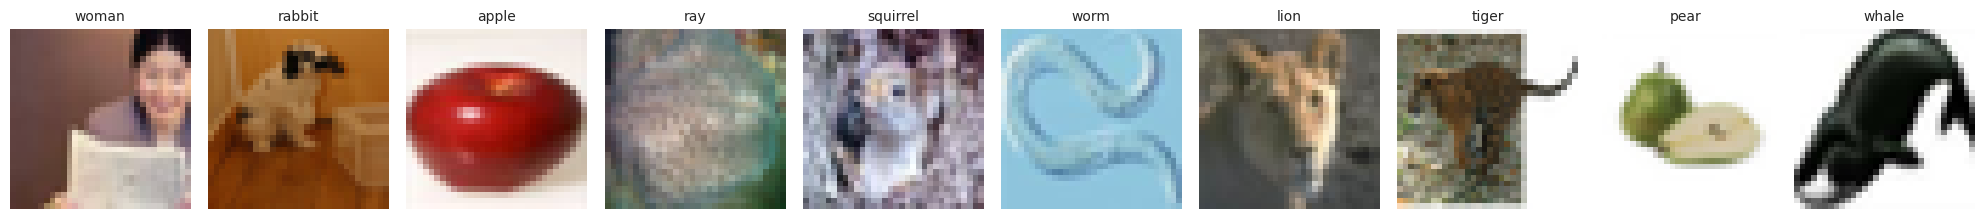

In [38]:
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
for i in range(10):
    index = random.randint(0, len(x_train) - 1)
    axes[i].imshow(x_train[index])
    label = y_train[index][0]
    axes[i].set_title(fine_labels[label], fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Se cuentan cuántas imágenes hay por clase y se construyó un dataframe con esa información.

In [39]:
unique, counts = np.unique(y_train, return_counts=True)

df_counts = pd.DataFrame({
    'Label ID': unique,
    'Label Name': [fine_labels[i] for i in unique],
    'Count': counts
})

df_counts_sorted = df_counts.sort_values(by='Count', ascending=False)
df_counts_sorted.head()

,Label ID,Label Name,Count
0,0,apple,500
63,63,porcupine,500
73,73,shark,500
72,72,seal,500
71,71,sea,500


Se grafica un barplot de las clases más comunes.

/tmp/ipykernel_23/237555424.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts_sorted.head(30), x='Label Name', y='Count', palette='viridis')


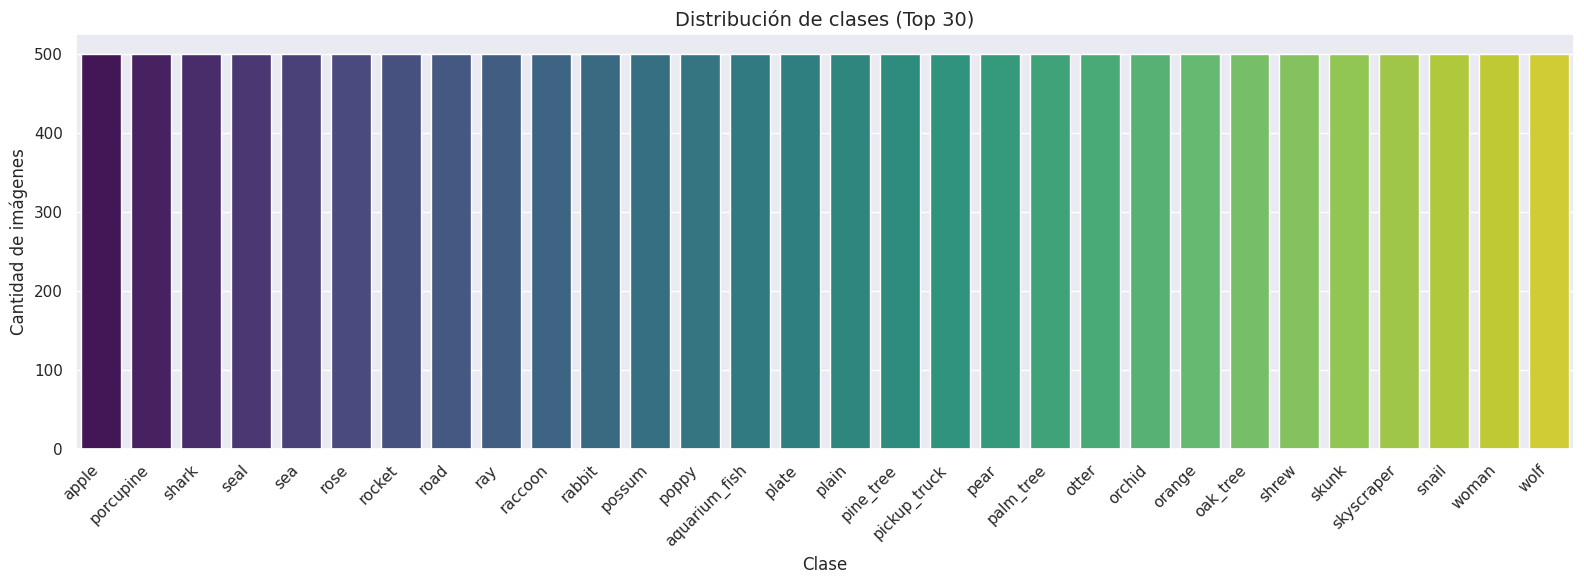

In [40]:
plt.figure(figsize=(16, 6))
sns.barplot(data=df_counts_sorted.head(30), x='Label Name', y='Count', palette='viridis')
plt.title('Distribución de clases (Top 30)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cantidad de imágenes')
plt.xlabel('Clase')
plt.tight_layout()
plt.show()

Se pasará a la preparación de los datos para ocuparlos en las redes neuronales para las clases [Preparación para la red de las clases] [Fase 3] 

## Carga de imágenes y etiquetas de las superclases

Se cargar las imágenes y etiquetas de CIFAR-100, usando las superclases (20 clases).

In [52]:
(x_train_sc, y_train_sc), (x_test_sc, y_test_sc) = cifar100.load_data(label_mode='coarse')

Se pasará a la preparación de los datos para ocuparlos en las redes neuronales para las superclases [Preparación para la red de las superclases] [Fase 3] 

# Fase 3 - Preparación de los datos

En esta fase se seleccionarán, limpiarán y transformarán los datos para que sean adecuados al modelado. Se abordarán problemas como valores faltantes, duplicados o inconsistencias, y se construirán nuevas variables cuando sea necesario, con el objetivo de obtener un conjunto de datos listo para aplicar las técnicas de modelado.

## Preparación para la red de las clases

Las imágenes son normalizadas (sus valores pasan de 0-255 a 0-1) para que la red neuronal pueda aprender de forma más eficiente.

In [9]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Las etiquetas se convierten a one-hot encoding para que la red pueda trabajar con ellas correctamente en la salida softmax.

In [10]:
y_train_cat = to_categorical(y_train, 100)
y_test_cat = to_categorical(y_test, 100)

Implementamos la técnica de Cutout que elimina aleatoriamente secciones rectangulares de las imágenes durante el entrenamiento.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def simple_cutout(image, size=8):
    """Versión simplificada de cutout para menor carga computacional"""
    h, w = image.shape[0], image.shape[1]
    
    # Centro aleatorio
    cx = np.random.randint(0, w)
    cy = np.random.randint(0, h)
    
    # Coordenadas del recorte
    x1 = max(0, cx - size//2)
    x2 = min(w, cx + size//2)
    y1 = max(0, cy - size//2)
    y2 = min(h, cy + size//2)
    
    # Aplicar máscara
    img_copy = image.copy()
    img_copy[y1:y2, x1:x2, :] = 0.0
    
    return img_copy

# Configurar el generador con menor transformación
datagen = ImageDataGenerator(
    preprocessing_function=simple_cutout,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Usar batch size mayor para acelerar el entrenamiento
batch_size = 128

# Generar los generadores
train_generator = datagen.flow(
    x_train, y_train_cat,
    batch_size=batch_size,
    subset='training'
)

val_generator = datagen.flow(
    x_train, y_train_cat,
    batch_size=batch_size,
    subset='validation'
)

Se pasa al modelado [Modelado de las redes neuronales para las clases] [Fase 4]

## Preparación para la red de las superclases

Se normalizan las imágenes en valores de píxeles de rango [0,1]

In [53]:
x_train_sc = x_train_sc.astype('float32') / 255.0
x_test_sc = x_test_sc.astype('float32') / 255.0

Se realiza la conversión de etiquetas a codificación one-hot.

In [54]:
y_train_cat_sc = to_categorical(y_train_sc, 20)
y_test_cat_sc = to_categorical(y_test_sc, 20)

Se crea el generador de imágenes con transformaciones aleatorias para fortalecer el entrenamiento y validación.

In [55]:
datagen_sc = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator_sc = datagen.flow(x_train_sc, y_train_cat_sc, batch_size=32, subset='training')
val_generator_sc = datagen.flow(x_train_sc, y_train_cat_sc, batch_size=32, subset='validation')

Se pasa al modelado [Modelado de las redes neuronales para las superclases] [Fase 4]

# Fase 4 - Modelado

En esta fase se seleccionarán los algoritmos de modelado más adecuados y se entrenarán los modelos utilizando el conjunto de datos preparado. Se ajustarán los parámetros de los modelos y se evaluarán los resultados preliminares para determinar qué técnicas ofrecen el mejor desempeño para cumplir con los objetivos planteados.

## Modelado de las redes neuronales para las clases

Construimos el modelo con mayor capacidad, usando bloques Inception mejorados y aumentando el número de filtros.

In [12]:
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf

def efficient_block(x, filters, kernel_size=3, regularization=1e-4):
    """Bloque convolucional eficiente con BatchNorm"""
    # Primera capa convolucional
    x = layers.Conv2D(filters, kernel_size, padding='same', 
                      kernel_regularizer=regularizers.l2(regularization))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    # Segunda capa convolucional
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(regularization))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    return x

# Construir modelo optimizado
def build_efficient_model(input_shape=(32, 32, 3), num_classes=100):
    inputs = layers.Input(shape=input_shape)
    
    # Bloque 1
    x = efficient_block(inputs, 64)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Bloque 2
    x = efficient_block(x, 128)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Bloque 3
    x = efficient_block(x, 256)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.4)(x)
    
    # Clasificación
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Crear el modelo
model = build_efficient_model()

# Mostrar resumen del modelo
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                            

Configuramos un optimizador Adam con una tasa de aprendizaje optimizada y compilamos el modelo con Label Smoothing.

In [13]:
checkpoint = ModelCheckpoint(
    'checkpoints/cnn_cifar100_efficient_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Usamos Adam para convergencia rápida
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compilar con label smoothing
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

Se configura el earlyStopping, el cual detiene el entrenamiento cuando la validación no mejora en 5 épocas seguidas, luego se configura ReduceLROnPlateau, el cual reduce la tasa de aprendizaje si la validación se estanca.

In [14]:
# Early stopping más agresivo
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reducción de tasa de aprendizaje
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

Se entrena el modelo con aumento de datos en cada lote, se le coloca validación automática, se implementa el guardado del mejor checkpoint, se le coloca la detención temprana si no mejora el modelo y se ajusta automáticamente el learning rate.

In [47]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 4.6315 - accuracy: 0.0474
Epoch 1: val_accuracy improved from -inf to 0.07190, saving model to checkpoints/cnn_cifar100_best.h5


/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - 186s 147ms/step - loss: 4.6315 - accuracy: 0.0474 - val_loss: 4.1910 - val_accuracy: 0.0719 - lr: 0.0100
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 4.1004 - accuracy: 0.0862
Epoch 2: val_accuracy improved from 0.07190 to 0.07900, saving model to checkpoints/cnn_cifar100_best.h5
1250/1250 [==============================] - 180s 144ms/step - loss: 4.1004 - accuracy: 0.0862 - val_loss: 4.2026 - val_accuracy: 0.0790 - lr: 0.0100
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 3.8937 - accuracy: 0.1146
Epoch 3: val_accuracy improved from 0.07900 to 0.11800, saving model to checkpoints/cnn_cifar100_best.h5
1250/1250 [==============================] - 180s 144ms/step - loss: 3.8937 - accuracy: 0.1146 - val_loss: 3.9214 - val_accuracy: 0.1180 - lr: 0.0100
Epoch 4/100
1250/1250 [==============================] - ETA: 0s - loss: 3.7671 - accuracy: 0.1353
Epoch 4: val_accuracy did not improve from 

Se pasa a la evaluación [Evaluación de las redes neuronales para las clases] [Fase 5]

## Modelado de las redes neuronales para las superclases

Se construye una Red Convolucional Profunda utilizando Inception Blocks, Batch Normalization y Dropout para mejorar la estabilidad, la capacidad de generalización y evitar el sobreajuste en los datos.

In [61]:
def inception_block_sc(x, filters):
    f1, f3, f5 = filters

    path1 = layers.Conv2D(f1, (1, 1), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    path1 = layers.LeakyReLU(alpha=0.1)(path1)

    path2 = layers.Conv2D(f3, (1, 1), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    path2 = layers.LeakyReLU(alpha=0.1)(path2)
    path2 = layers.Conv2D(f3, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(path2)
    path2 = layers.LeakyReLU(alpha=0.1)(path2)

    path3 = layers.Conv2D(f5, (1, 1), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    path3 = layers.LeakyReLU(alpha=0.1)(path3)
    path3 = layers.Conv2D(f5, (5, 5), padding='same', kernel_regularizer=regularizers.l2(1e-4))(path3)
    path3 = layers.LeakyReLU(alpha=0.1)(path3)

    path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(f1, (1, 1), padding='same', kernel_regularizer=regularizers.l2(1e-4))(path4)
    path4 = layers.LeakyReLU(alpha=0.1)(path4)

    return layers.concatenate([path1, path2, path3, path4], axis=-1)

input_layer_sc = layers.Input(shape=(32, 32, 3))

x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(input_layer_sc)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

x = inception_block_sc(x, filters=(64, 96, 128))
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

x = inception_block_sc(x, filters=(64, 96, 128))
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

output_sc = layers.Dense(20, activation='softmax')(x)

model_sc = models.Model(inputs=input_layer_sc, outputs=output_sc)

Definición de las funciones clave que controlarán el aprendizaje y la estabilidad del modelo como SGD con Nesterov Momentum para una convergencia más rápida y precisa, EarlyStopping para detener el entrenamiento cuando la validación deja de mejorar, evitando el sobreentrenamiento, ModelCheckpoint para guardar automáticamente el mejor modelo durante el entrenamiento y ReduceLROnPlateau para ajustar dinámicamente la tasa de aprendizaje cuando el rendimiento se estanca.

In [64]:
optimizer_sc = SGD(learning_rate=1e-2, momentum=0.9, nesterov=True)
model_sc.compile(optimizer=optimizer_sc, loss='categorical_crossentropy', metrics=['accuracy'])
early_stop_sc = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
checkpoint_cb_sc = ModelCheckpoint(filepath='checkpoints/cnn_cifar100_superclass_best.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr_sc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

Se entrena el modelo con aumento de datos en cada lote, se le coloca validación automática, se implementa el guardado del mejor checkpoint, se le coloca la detención temprana si no mejora el modelo y se ajusta automáticamente el learning rate.

In [65]:
history_sc = model_sc.fit(
    train_generator_sc,
    epochs=50,
    validation_data=val_generator_sc,
    callbacks=[early_stop_sc, checkpoint_cb_sc, reduce_lr_sc],
    verbose=1
)

Epoch 1/50
1250/1250 [==============================] - ETA: 0s - loss: 3.1288 - accuracy: 0.1377
Epoch 1: val_accuracy improved from -inf to 0.18350, saving model to checkpoints/cnn_cifar100_superclass_best.h5
1250/1250 [==============================] - 189s 148ms/step - loss: 3.1288 - accuracy: 0.1377 - val_loss: 2.8148 - val_accuracy: 0.1835 - lr: 0.0100
Epoch 2/50
1250/1250 [==============================] - ETA: 0s - loss: 2.7432 - accuracy: 0.2056
Epoch 2: val_accuracy did not improve from 0.18350
1250/1250 [==============================] - 181s 145ms/step - loss: 2.7432 - accuracy: 0.2056 - val_loss: 2.8139 - val_accuracy: 0.1810 - lr: 0.0100
Epoch 3/50
1250/1250 [==============================] - ETA: 0s - loss: 2.5741 - accuracy: 0.2521
Epoch 3: val_accuracy improved from 0.18350 to 0.25410, saving model to checkpoints/cnn_cifar100_superclass_best.h5
1250/1250 [==============================] - 204s 163ms/step - loss: 2.5741 - accuracy: 0.2521 - val_loss: 2.5841 - val_accura

Se pasa a la evaluación [Evaluación de las redes neuronales para las superclases] [Fase 5]

# Fase 5 - Evaluación

En la fase de evaluación se analizará el rendimiento de los modelos desarrollados, comparándolos con los objetivos del negocio para asegurar que sean útiles y precisos. Se tomará en cuenta la validez de los resultados, se decidirá si es necesario ajustar los modelos o si están listos para su implementación.

## Evaluación de las redes neuronales para las clases

Se evalua la calidad final del modelo usando datos totalmente nuevos y no vistos durante el entrenamiento.

In [15]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('checkpoints/cnn_cifar100_efficient_best.h5')

# Ahora puedes evaluar el modelo
test_loss, test_accuracy = model.evaluate(x_test, y_test_cat)
print(f"🔍 Test accuracy: {test_accuracy:.4f}")
print(f"📉 Test loss: {test_loss:.4f}")

2025-04-22 19:14:01.430133: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 [==============================] - 15s 46ms/step - loss: 2.3862 - accuracy: 0.6104
🔍 Test accuracy: 0.6104
📉 Test loss: 2.3862


Se graficaron las curvas de precisión y pérdida para el entrenamiento y la validación del modelo.

In [18]:
# 2. Obtener predicciones en conjunto de prueba
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# 3. Calcular exactitud global
accuracy = np.mean(y_pred == y_true)
print(f"Exactitud del modelo: {accuracy:.4f}")

2025-04-22 19:19:35.604818: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 [==============================] - 13s 42ms/step
Exactitud del modelo: 0.6104


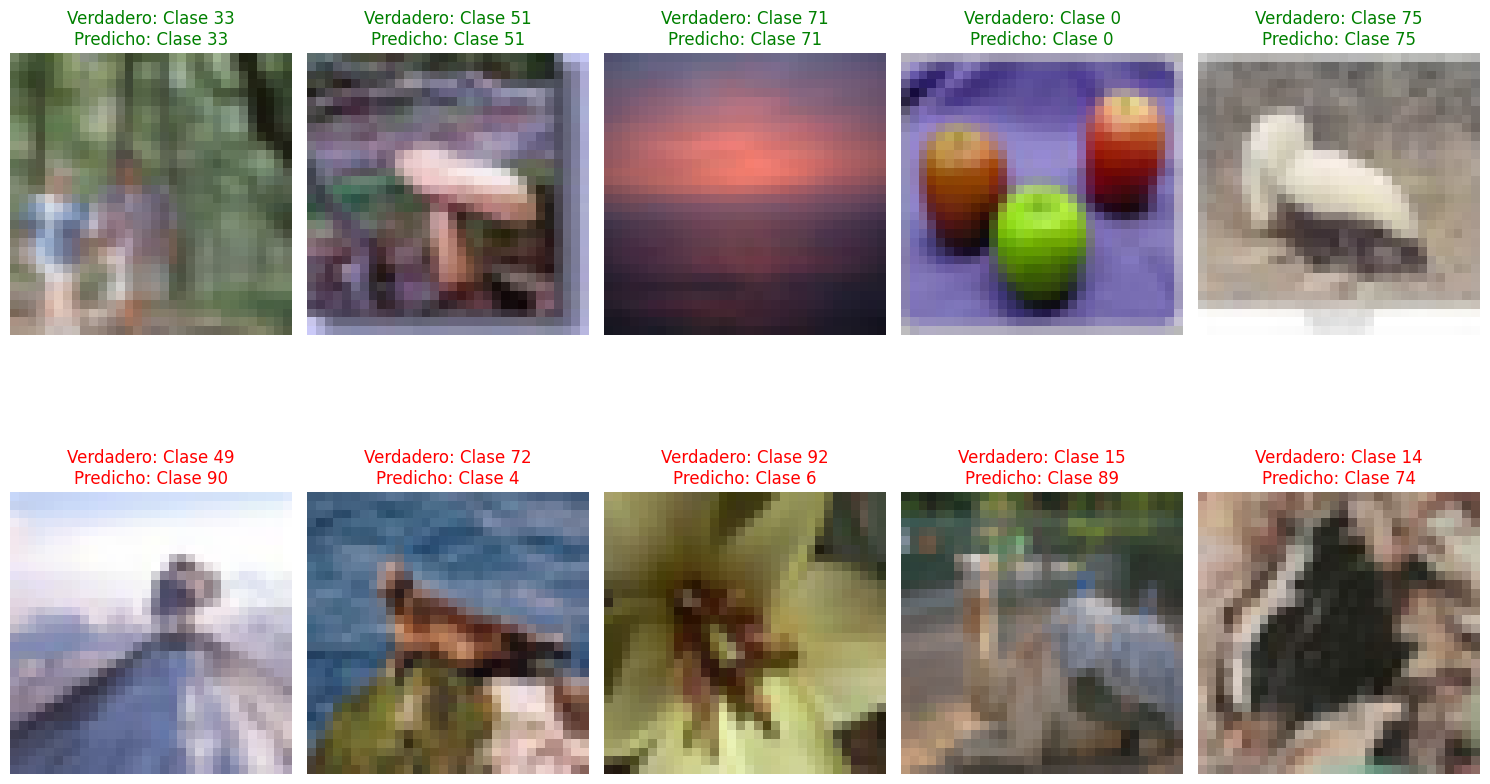

In [19]:
# 4. Visualización 1: Ejemplos de predicciones correctas e incorrectas
plt.figure(figsize=(15, 10))

# Nombres de clases CIFAR-100 (si no tienes estos, puedes usar índices)
# Esta es una lista simplificada, CIFAR-100 tiene 100 clases
class_names = [f"Clase {i}" for i in range(100)]  # Reemplaza con nombres reales si los tienes

# Obtener ejemplos de predicciones correctas
correct_idx = np.where(y_pred == y_true)[0]
# Obtener ejemplos de predicciones incorrectas
incorrect_idx = np.where(y_pred != y_true)[0]

# Mostrar 5 predicciones correctas
for i, idx in enumerate(correct_idx[:5]):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[idx].reshape(32, 32, 3))
    plt.title(f"Verdadero: {class_names[y_true[idx]]}\nPredicho: {class_names[y_pred[idx]]}", color='green')
    plt.axis('off')

# Mostrar 5 predicciones incorrectas
for i, idx in enumerate(incorrect_idx[:5]):
    plt.subplot(2, 5, i+6)
    plt.imshow(x_test[idx].reshape(32, 32, 3))
    plt.title(f"Verdadero: {class_names[y_true[idx]]}\nPredicho: {class_names[y_pred[idx]]}", color='red')
    plt.axis('off')

plt.tight_layout()
plt.savefig('ejemplos_prediccion.png')
plt.show()

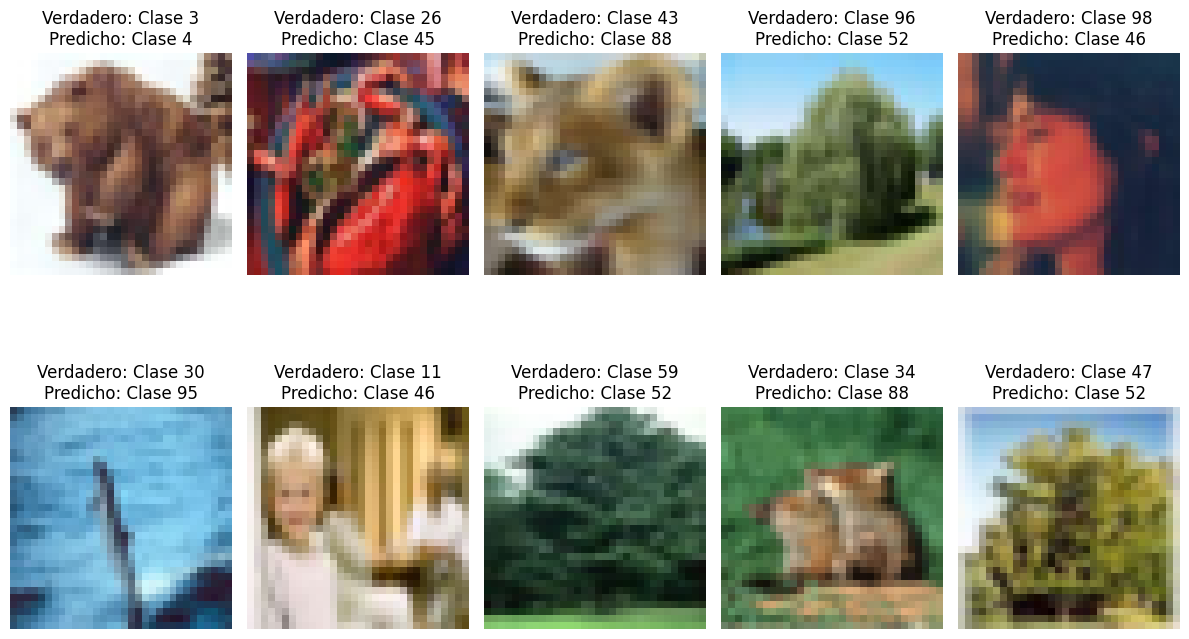

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
# 5. Visualización 2: Top-5 clases más confundidas
conf_mat = confusion_matrix(y_true, y_pred)
np.fill_diagonal(conf_mat, 0)  # Eliminar diagonal para enfocarse en errores
most_confused = np.dstack(np.unravel_index(np.argsort(conf_mat.ravel())[-10:], conf_mat.shape))[0]

plt.figure(figsize=(12, 8))
for i, (true_class, pred_class) in enumerate(most_confused):
    plt.subplot(2, 5, i+1)
    idx = np.where((y_true == true_class) & (y_pred == pred_class))[0][0]
    plt.imshow(x_test[idx].reshape(32, 32, 3))
    plt.title(f"Verdadero: {class_names[true_class]}\nPredicho: {class_names[pred_class]}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('clases_confundidas.png')
plt.show()

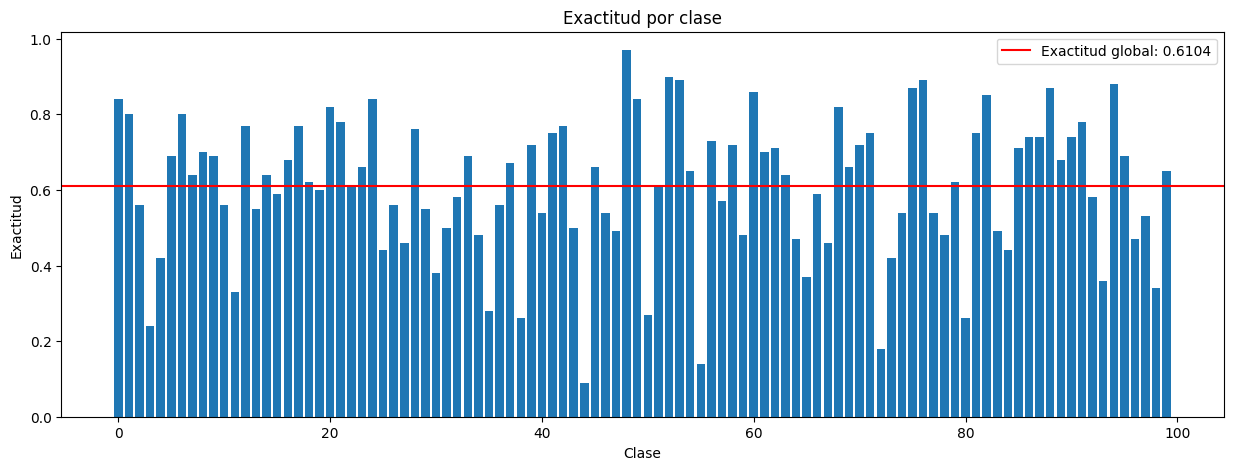

In [21]:
# 6. Visualización 3: Distribución de precisión por clase
class_accuracy = np.zeros(100)
for i in range(100):
    class_indices = np.where(y_true == i)[0]
    if len(class_indices) > 0:
        class_accuracy[i] = np.mean(y_pred[class_indices] == i)

plt.figure(figsize=(15, 5))
plt.bar(range(100), class_accuracy)
plt.xlabel('Clase')
plt.ylabel('Exactitud')
plt.title('Exactitud por clase')
plt.axhline(y=accuracy, color='r', linestyle='-', label=f'Exactitud global: {accuracy:.4f}')
plt.legend()
plt.savefig('precision_por_clase.png')
plt.show()

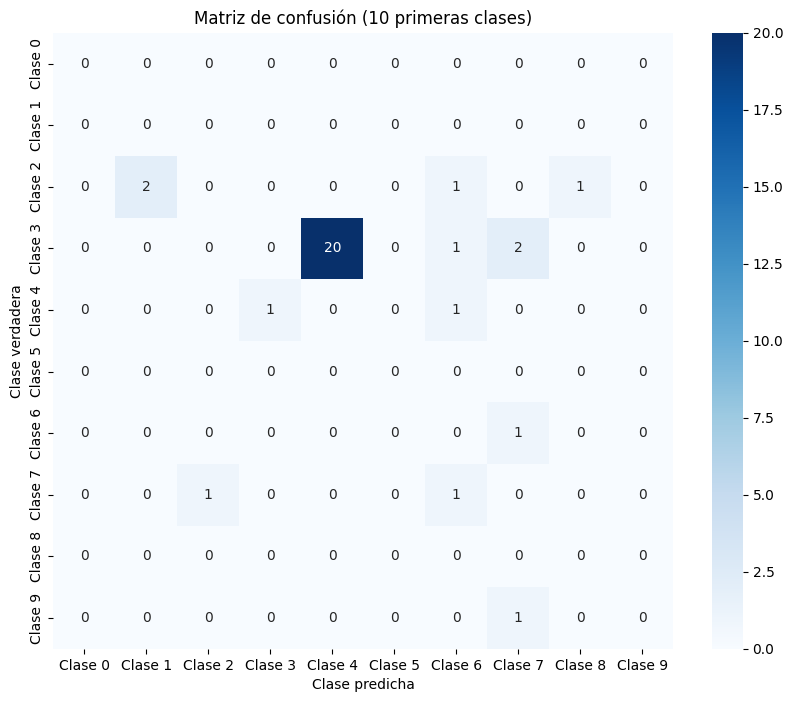

In [22]:
import seaborn as sns
# 7. Visualización 4: Matriz de confusión para las 10 primeras clases
plt.figure(figsize=(10, 8))
conf_mat_subset = conf_mat[:10, :10]  # Tomar solo las primeras 10 clases para legibilidad
sns.heatmap(conf_mat_subset, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names[:10], yticklabels=class_names[:10])
plt.xlabel('Clase predicha')
plt.ylabel('Clase verdadera')
plt.title('Matriz de confusión (10 primeras clases)')
plt.savefig('matriz_confusion.png')
plt.show()

Se pasará a la comprensión de los datos para cargar las superclases [Carga de imágenes y etiquetas de las superclases] [Fase 2] 

## Evaluación de las redes neuronales para las superclases

Se evalua la calidad final del modelo usando datos totalmente nuevos y no vistos durante el entrenamiento.

In [67]:
test_loss_sc, test_accuracy_sc = model_sc.evaluate(x_test_sc, y_test_cat_sc)
print(f"🔍 Test accuracy: {test_accuracy_sc:.4f}")
print(f"📉 Test loss: {test_loss_sc:.4f}")

313/313 [==============================] - 10s 31ms/step - loss: 1.4237 - accuracy: 0.6046
🔍 Test accuracy: 0.6046
📉 Test loss: 1.4237


Se graficaron las curvas de precisión y pérdida para el entrenamiento y la validación del modelo.

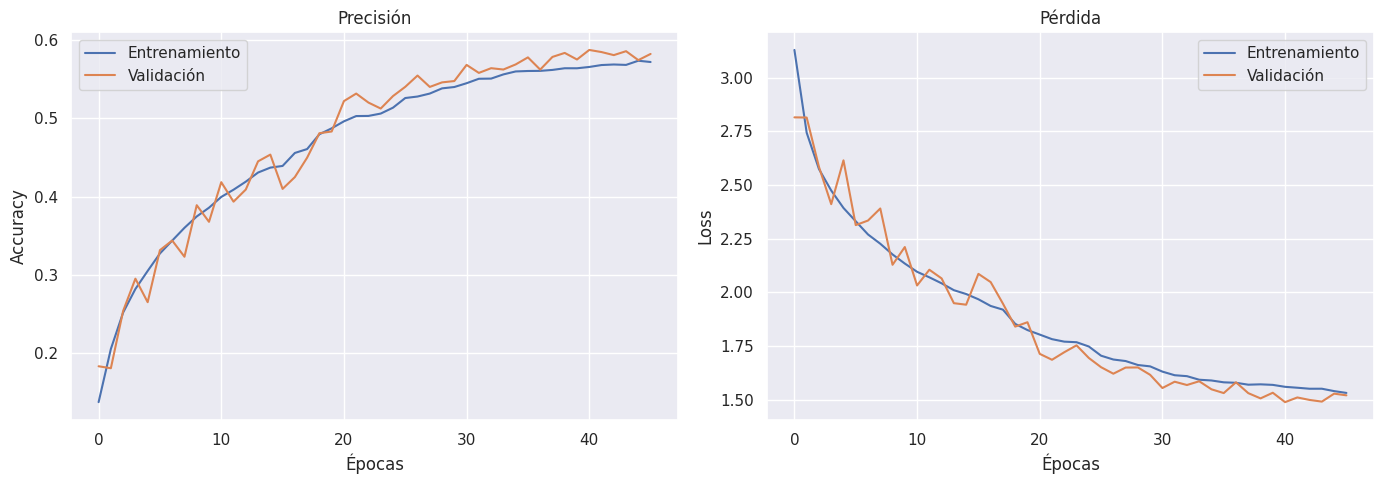

In [70]:
def plot_history_sc(hist_sc):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(hist_sc.history['accuracy'], label='Entrenamiento')
    plt.plot(hist_sc.history['val_accuracy'], label='Validación')
    plt.title('Precisión')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist_sc.history['loss'], label='Entrenamiento')
    plt.plot(hist_sc.history['val_loss'], label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history_sc(history_sc)

# Fase 6 - Implementación

En esta fase los modelos serán implementados en un entorno productivo para su uso real. Se generarán reportes detallados sobre los resultados y se establecerá un plan de mantenimiento y actualización periódica para asegurar la continua eficacia del modelo en el tiempo.

## 🧱 Modelo CNN mejorado con regularización, normalización y data augmentation (de acuerdo a la rúbrica)

# 🛠️ Mejora del modelo CNN con Data Augmentation y Regularización Avanzada
Notebook 03.5 – Mejora adicional del modelo CNN
En este notebook aplicamos técnicas adicionales para mejorar el rendimiento del modelo CNN:

- Aumento de datos avanzado (Cutout)
- Arquitectura mejorada con más filtros
- Esquema de optimización cíclico
- Label Smoothing
- Normalización mejorada

---


## 🔁 1. Carga y preprocesamiento de datos
Cargamos el dataset CIFAR-100 y aplicamos normalización avanzada usando la media y desviación estándar del conjunto de entrenamiento.


## 🔍 2. Normalización mejorada
Mejoramos la normalización calculando la media y desviación estándar del conjunto de entrenamiento para cada canal.


## 🔄 3. Aumento de datos avanzado (Cutout)
Implementamos la técnica de Cutout que elimina aleatoriamente secciones rectangulares de las imágenes durante el entrenamiento.


## ⚙️ 6. Configuración del optimizador y compilación
Configuramos un optimizador Adam con una tasa de aprendizaje optimizada y compilamos el modelo con Label Smoothing.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def simple_cutout(image, size=8):
    """Versión simplificada de cutout para menor carga computacional"""
    h, w = image.shape[0], image.shape[1]
    
    # Centro aleatorio
    cx = np.random.randint(0, w)
    cy = np.random.randint(0, h)
    
    # Coordenadas del recorte
    x1 = max(0, cx - size//2)
    x2 = min(w, cx + size//2)
    y1 = max(0, cy - size//2)
    y2 = min(h, cy + size//2)
    
    # Aplicar máscara
    img_copy = image.copy()
    img_copy[y1:y2, x1:x2, :] = 0.0
    
    return img_copy

# Configurar el generador con menor transformación
datagen = ImageDataGenerator(
    preprocessing_function=simple_cutout,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Usar batch size mayor para acelerar el entrenamiento
batch_size = 128

# Generar los generadores
train_generator = datagen.flow(
    x_train, y_train_cat,
    batch_size=batch_size,
    subset='training'
)

val_generator = datagen.flow(
    x_train, y_train_cat,
    batch_size=batch_size,
    subset='validation'
)

In [6]:
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf

def efficient_block(x, filters, kernel_size=3, regularization=1e-4):
    """Bloque convolucional eficiente con BatchNorm"""
    # Primera capa convolucional
    x = layers.Conv2D(filters, kernel_size, padding='same', 
                      kernel_regularizer=regularizers.l2(regularization))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    # Segunda capa convolucional
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(regularization))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    
    return x

# Construir modelo optimizado
def build_efficient_model(input_shape=(32, 32, 3), num_classes=100):
    inputs = layers.Input(shape=input_shape)
    
    # Bloque 1
    x = efficient_block(inputs, 64)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Bloque 2
    x = efficient_block(x, 128)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Bloque 3
    x = efficient_block(x, 256)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.4)(x)
    
    # Clasificación
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Crear el modelo
model = build_efficient_model()

# Mostrar resumen del modelo
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                            

In [7]:
# Usamos Adam para convergencia rápida
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compilar con label smoothing
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

In [17]:
# Entrenamos con menos épocas pero suficientes para ver mejoras
history = model.fit(
    train_generator,
    epochs=50,  # Menos épocas
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 4.4511 - accuracy: 0.0667
Epoch 1: val_accuracy improved from -inf to 0.03890, saving model to checkpoints/cnn_cifar100_efficient_best.h5


/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 278s 881ms/step - loss: 4.4511 - accuracy: 0.0667 - val_loss: 4.9652 - val_accuracy: 0.0389 - lr: 0.0010
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 3.9775 - accuracy: 0.1309
Epoch 2: val_accuracy improved from 0.03890 to 0.12000, saving model to checkpoints/cnn_cifar100_efficient_best.h5
313/313 [==============================] - 260s 829ms/step - loss: 3.9775 - accuracy: 0.1309 - val_loss: 4.0400 - val_accuracy: 0.1200 - lr: 0.0010
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 3.6700 - accuracy: 0.1953
Epoch 3: val_accuracy improved from 0.12000 to 0.20860, saving model to checkpoints/cnn_cifar100_efficient_best.h5
313/313 [==============================] - 253s 809ms/step - loss: 3.6700 - accuracy: 0.1953 - val_loss: 3.6180 - val_accuracy: 0.2086 - lr: 0.0010
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 3.4612 - accuracy: 0.2453
Epoch 4: val_accuracy improved from 0.